# 04 - Tidy Up

## Overview
My goal in this notebook is to tuck away re-usable or repeated code into modules.
* Feature and response queries -> features.py
* Preprocessing bits -> preprocessing.py
* Backtest computations -> backtest.py
* Backtest presentation -> backtest.py
* Training? I might leave this to a second round of tidying up.
* Scoring? I might leave this to a second round of tidying up.

# Features

I'm considering breaking features into conceptual sets ... these would then need to be horizontally concatenated (joined) before being run through a model.   It's not that they cannot all live in the same query - but it makes things a bit more management memory wise as well as my own sanity to split up:
* RFM - Basic features that, essentially, dominate and produce great results with Logistic Regression
* Time slicing
  * Time slice for on-line transactions
  * Time slice for in-store transactions
  * Time slice for all transactions (I do not know if there are things to be learned by splitting up)
  * Variations of timeslice where I overlap periods and do not overlap periods ... so total of 6 sets of features
* Time shifting
  * I'm not ready yet for this, but I'll assure all feature creation is parameterized for time shifting
* Product & category related features
  * These will be in a future notebook ... basically an "encoding" of who a customer is based on what they buy likely time sliced (to a degree) ... I simply do not know if someone's likelihood to buy is related to what they recently bought
* Seasonality + Maybe Regional
  * Intended for a future notebook and related to time shifting ... fashion retail is definitely regional and seasonal
  * The data source has hashed postal codes - so it is not possible to figure the regions - but I might (not in this notebook) try to cluster postal codes to get some rough mapping of postal code -> some meaningful grouping and then use that for regional bias features for seasonality ... all rough ideas right now
* Customer features
  * There are a handful of customer features that have no importance - but I'll keep in
  * Along with these "demographic" type features I plan to include high level (not time based) transaction statistics, such as:
    * Average order value (AOV) (in feature period)
    * Average discount rate (in feature period) ... note the data set does NOT have original price but this can be figured out


Note: I am running against memory issues on my laptop going from DuckDB to Polars when I have too many columns. A quick fix was to use disk: `dataset.duckdb_conn.execute("PRAGMA memory_limit='50GB';")`   Its fast (or fast enough) but I'm looking in a later notebook to increase the rows by 13, 26, and 52 (which I'll likely do in loops anyway and write to disk so I will not need to rerun the features creation each time I re-start the notebook).



In [59]:

import sys
import polars as pl
import importlib


sys.path.append('../pipeline')
from dataset import CSVDataset, KaggleDataset
from evaluate import Evaluator

import features
importlib.reload(features)
from features import Features


In [44]:
# for name in list(globals().keys()):
#     if name not in ["__builtins__", "__name__", "__doc__"]:
#         del globals()[name]
# import gc
# gc.collect()

In [8]:
# kaggle_dataset = KaggleDataset()
# kaggle_dataset.load()

In [5]:
dataset = CSVDataset('../data/',["articles.csv","transactions_train.csv","customers.csv"])
dataset.load()


Loading ../data/articles.csv
Loading ../data/transactions_train.csv
Loading ../data/customers.csv


In [60]:

# trying this out ... a set of constants for each: training, backtest, inference - but not sure
# from dataclasses import dataclass
# from datetime import date
#
from dataclasses import dataclass
from datetime import date

@dataclass(frozen=True)
class QueryConstants:
    end_date: date = date(2020, 9, 22)
    feature_duration: int = 365
    response_duration: int = 28
    additional_offset: int = 28

training_constants = QueryConstants()

features = Features(**vars(training_constants))

label_df = features.get_response_label(dataset.duckdb_conn)
#feature_df = features.get_time_sliced_no_overlap(dataset.duckdb_conn)
feature_df = features.get_customer_features(dataset.duckdb_conn)

# display(response_df)
# display(label_df)


In [4]:
# from datetime import date, timedelta
#
# # Eventually I will be creating complex features so query will likely be generated
# # and then there will be windows of responses and features as well
# # I'm undecided at this point so I might simply put this in a class with three methods
# # one to get features, one to get label, and one to get backtest
#
# class QueryConstants:
#     end_date=date(2020,9,22)
#     feature_duration=365
#     label_duration=30
#     backtest_duration=30
#     label_end =  end_date - timedelta(days=backtest_duration)
#     feature_end = label_end - timedelta(days=label_duration)
#     feature_start = feature_end - timedelta(days=feature_duration)
#
# response_query = """
#         SELECT
#             t.customer_id,
#             MAX(
#                 CASE
#                     WHEN t.t_dat > DATE '{response_start}'  AND t.t_dat <= DATE '{response_end}'  THEN 1
#                     ELSE 0
#                 END
#             ) AS label
#         FROM transactions t
#         INNER JOIN customers c ON c.customer_id = t.customer_id
#         GROUP BY t.customer_id
# """
#
#
# feature_query = '''
# SELECT *
#     ,SQRT(t_count_quarter_1*t_count_quarter_2) as q1_x_q2
#     ,SQRT(t_count_quarter_1*t_count_quarter_3) as q1_x_q3
#     ,SQRT(t_count_quarter_1*t_count_quarter_4) as q1_x_q4
#     ,SQRT(t_count_quarter_2*t_count_quarter_3) as q2_x_q3
#     ,SQRT(t_count_quarter_2*t_count_quarter_4) as q2_x_q4
#     ,SQRT(t_count_quarter_3*t_count_quarter_4) as q3_x_q4
#     ,POWER(t_count_quarter_1*t_count_quarter_2*t_count_quarter_3*t_count_quarter_4,0.25) as q1_x_q2_x_q3_x_q4
# FROM (
#     SELECT
#         t.customer_id
#
#         ,SUM(CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (84*1) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (84*(1 - 1)) DAY THEN 1 ELSE 0 END)
#             as t_count_quarter_1
#         ,COUNT(DISTINCT CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (84*1) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (84*(1 - 1)) DAY THEN t.t_dat ELSE NULL END)
#             as ti_count_quarter_1
#         ,SUM(CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (84*1) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (84*(1 - 1)) DAY THEN 590*price ELSE 0 END)
#             as revenue_quarter_1
#
#
#         ,SUM(CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (84*2) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (84*(2 - 1)) DAY THEN 1 ELSE 0 END)
#             as t_count_quarter_2
#         ,COUNT(DISTINCT CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (84*2) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (84*(2 - 1)) DAY THEN t.t_dat ELSE NULL END)
#             as ti_count_quarter_2
#         ,SUM(CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (84*2) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (84*(2 - 1)) DAY THEN 590*price ELSE 0 END)
#             as revenue_quarter_2
#
#
#         ,SUM(CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (84*3) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (84*(3 - 1)) DAY THEN 1 ELSE 0 END)
#             as t_count_quarter_3
#         ,COUNT(DISTINCT CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (84*3) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (84*(3 - 1)) DAY THEN t.t_dat ELSE NULL END)
#             as ti_count_quarter_3
#         ,SUM(CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (84*3) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (84*(3 - 1)) DAY THEN 590*price ELSE 0 END)
#             as revenue_quarter_3
#
#
#         ,SUM(CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (84*4) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (84*(4 - 1)) DAY THEN 1 ELSE 0 END)
#             as t_count_quarter_4
#         ,COUNT(DISTINCT CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (84*4) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (84*(4 - 1)) DAY THEN t.t_dat ELSE NULL END)
#             as ti_count_quarter_4
#         ,SUM(CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (84*4) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (84*(4 - 1)) DAY THEN 590*price ELSE 0 END)
#             as revenue_quarter_4
#
#
#         ,SUM(CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (28*13) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (28*(13 - 1)) DAY THEN 1 ELSE 0 END)
#             as t_count_month_13
#         ,COUNT(DISTINCT CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (28*13) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (28*(13 - 1)) DAY THEN t.t_dat ELSE NULL END)
#             as ti_count_month_13
#         ,SUM(CASE WHEN t.t_dat > DATE '{feature_end}' - INTERVAL (28*13) DAY AND t.t_dat <= DATE '{feature_end}' - INTERVAL (28*(13 - 1)) DAY THEN 590*price ELSE 0 END)
#             as revenue_month_13
#
#
#         ,COUNT(1) total_transaction_items
#         ,MAX(t.t_dat) - DATE '{feature_end}' as days_since_last
#         --TODO: Perhaps make the channel data driven
#         ,MAX(CASE WHEN sales_channel_id = 1 THEN t.t_dat ELSE DATE '{feature_start}' END) - DATE '{feature_end}' as days_since_last_channel_1
#         ,MAX(CASE WHEN sales_channel_id = 2 THEN t.t_dat ELSE DATE '{feature_start}' END) - DATE '{feature_end}' as days_since_last_channel_2
#         ,ROUND(590*SUM(price)) as total_revenue
#         ,COUNT(DISTINCT t.t_dat) as total_transactions
#         ,ROUND(ROUND(590*SUM(price))/COUNT(DISTINCT t.t_dat)) as aov
#         ,SUM(CASE WHEN sales_channel_id = 1 THEN 1 ELSE 0 END) AS sales_channel_01
#         ,SUM(CASE WHEN sales_channel_id = 2 THEN 1 ELSE 0  END) AS sales_channel_02
#         ,MAX(CASE WHEN COALESCE(c.FN,0) = 1 THEN 1 ELSE 0 END) AS customer_fn
#         ,MAX(CASE WHEN COALESCE(c.active,0) = 1 THEN 1 ELSE 0 END) AS customer_active
#         ,MAX(CASE WHEN COALESCE(c.fashion_news_frequency, 'Empty') in ('Monthly','Reqularly') THEN 1 ELSE 0 END) AS customer_fashion_news_frequency
#
#     FROM transactions t
#     INNER JOIN customers c ON t.customer_id = c.customer_id
#     WHERE t.t_dat <= DATE '{feature_end}' and t.t_dat > DATE '{feature_start}'
#     --and customer_id = '00d40c65c316c02eac7fb0c628afbf57d616eed4b08f69ecfc115ca643a308af'
#     GROUP BY t.customer_id
# ) x
# '''
#
# label_query = response_query.format(response_start=QueryConstants.feature_end, response_end=QueryConstants.label_end)
# backtest_response_query = response_query.format(response_start=QueryConstants.label_end, response_end=QueryConstants.end_date)
#
# arrow_table = dataset.duckdb_conn.execute(label_query).fetch_arrow_table()
# label_df = pl.from_arrow(arrow_table)
#
# arrow_table = dataset.duckdb_conn.execute(backtest_response_query).fetch_arrow_table()
# backtest_response_df = pl.from_arrow(arrow_table)
#
# query = feature_query.format(**vars(QueryConstants))
# arrow_table = dataset.duckdb_conn.execute(query).fetch_arrow_table()
# feature_df = pl.from_arrow(arrow_table)
#
#
# display(feature_df)


In [61]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_percentile=0.01, upper_percentile=99.99):
        """
        Initialize the Winsorizer with percentiles for lower and upper bounds.

        Args:
            lower_percentile (float): The lower percentile for winsorization (e.g., 5 for 5th percentile).
            upper_percentile (float): The upper percentile for winsorization (e.g., 95 for 95th percentile).
        """
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile
        self.bounds_ = None  # To store computed bounds during fitting

    def fit(self, X, y=None):
        """
        Compute the lower and upper bounds for each feature in the data.

        Args:
            X (array-like): The input data (2D array).
            y (ignored): Not used, for compatibility with Scikit-learn API.
        """
        X = np.asarray(X)
        # Add debugging to check the shape of the input
        if X.ndim != 2:
            raise ValueError(f"Expected 2D input, got {X.ndim}D input with shape {X.shape}")

        # Compute bounds
        self.bounds_ = {}
        for col in range(X.shape[1]):
            self.bounds_[col] = {
                "lower": np.percentile(X[:, col], self.lower_percentile),
                "upper": np.percentile(X[:, col], self.upper_percentile),
            }
        return self

    def transform(self, X):
        """
        Apply winsorization to the data using the computed bounds.

        Args:
            X (array-like): The input data (2D array).

        Returns:
            np.ndarray: The winsorized data.
        """
        if self.bounds_ is None:
            raise ValueError("Winsorizer has not been fitted yet.")

        X = np.asarray(X)
        if X.ndim != 2:
            raise ValueError(f"Expected 2D input, got {X.ndim}D input with shape {X.shape}")

        # Apply winsorization
        X_winsorized = X.copy()
        for col, bounds in self.bounds_.items():
            X_winsorized[:, col] = np.clip(X[:, col], bounds["lower"], bounds["upper"])
        return X_winsorized


In [62]:
# preprocessing
# 1. Split train/test

from sklearn.model_selection import train_test_split

aligned_df = feature_df.join(label_df, on="customer_id")
aligned_df  = aligned_df.sample(n=aligned_df.height, with_replacement=False)

display(aligned_df)

# Automatically separate features and labels
excluded_columns = ["customer_id", "label"]  # Columns to exclude
feature_columns = [col for col in aligned_df.columns if col not in excluded_columns]

# Split into features (X) and labels (y)
X = aligned_df.select(feature_columns).to_numpy()
y = aligned_df["label"].to_numpy()

# Step 1: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

print(type(X_train))
#print(X_train.shape)






customer_id,aov,customer_active,customer_fashion_news_frequency,customer_fn,percent_sales_channel_01,percent_sales_channel_02,age,label
str,f64,i32,i32,i32,f64,f64,i64,i32
"""5a836842e8d18c0bdc20e53d1c164a…",66.0,0,0,0,0.0,1.0,24,1
"""5af7345b9891263331012f7b6d0f18…",147.0,0,0,0,0.0,1.0,28,1
"""5b5de44efd7296d8992e3675a063c0…",88.0,0,0,0,0.0,1.0,22,1
"""5c80a591e328613f43c5a7bb69f703…",44.0,0,0,0,1.0,0.0,26,1
"""5ca6096c3bc40d8517cc23f3482de7…",26.0,0,0,0,0.0,1.0,27,0
…,…,…,…,…,…,…,…,…
"""6c2423ab0a03bbd3d3f51fcbf3e3fe…",26.0,1,0,1,0.0,1.0,21,0
"""6effb7a68a6a078f19e8ddce6bbc62…",351.0,0,0,0,0.0,1.0,20,0
"""753bc214eac4c857cbf848804f2c50…",30.0,0,0,0,0.0,1.0,38,0


<class 'numpy.ndarray'>


In [63]:
# Winsorize for extreme values

winsorizer = Winsorizer(lower_percentile=0.01, upper_percentile=99.99)

winsorizer.fit(X_train)

print(winsorizer.bounds_)
X_train_winsorized = winsorizer.transform(X_train)

print(sys.getsizeof(X_train))







{0: {'lower': 1.0, 'upper': 862.0}, 1: {'lower': 0.0, 'upper': 1.0}, 2: {'lower': 0.0, 'upper': 1.0}, 3: {'lower': 0.0, 'upper': 1.0}, 4: {'lower': 0.0, 'upper': 1.0}, 5: {'lower': 0.0, 'upper': 1.0}, 6: {'lower': -1.0, 'upper': 88.0}}
49558560


In [64]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

standard_scaler.fit(X_train_winsorized)

X_train_standardized = standard_scaler.transform(X_train_winsorized)

print(standard_scaler.mean_)
print(standard_scaler.scale_)

[5.69676487e+01 3.60533441e-01 3.75153112e-04 3.67297496e-01
 3.14891319e-01 7.01426712e-01 3.55467145e+01]
[5.10788843e+01 4.80155265e-01 1.93652362e-02 4.82068507e-01
 4.64472578e-01 4.57632254e-01 1.45615609e+01]


In [130]:
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# smote = SMOTE(random_state=42)  # Initialize SMOTE
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train_standardized, y_train)
#
# # Initialize RandomUnderSampler for under-sampling
# undersampler = RandomUnderSampler(random_state=42)
# X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train_standardized, y_train)
#
#
# print(X_train_standardized.shape)
# print(X_train_balanced.shape)
# print(y_train_balanced.shape)

In [65]:
# training - cut and paste for now

import polars as pl

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

# model = LogisticRegression()
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)


model.fit(X_train_standardized, y_train)

# # Compute AUC for training set
y_train_prob = model.predict_proba(X_train_standardized)[:, 1]  # Probabilities for the positive class
train_auc = roc_auc_score(y_train, y_train_prob)
#
print(train_auc)







0.612255031516991


Computing optimal Threshold: 0.2
Computing predictions...
AUC: 0.61
Optimal Threshold: 0.2
Maximum F1 Score: 0.36
              precision    recall  f1-score   support

           0       0.84      0.55      0.66    699411
           1       0.26      0.60      0.36    185561

    accuracy                           0.56    884972
   macro avg       0.55      0.58      0.51    884972
weighted avg       0.72      0.56      0.60    884972



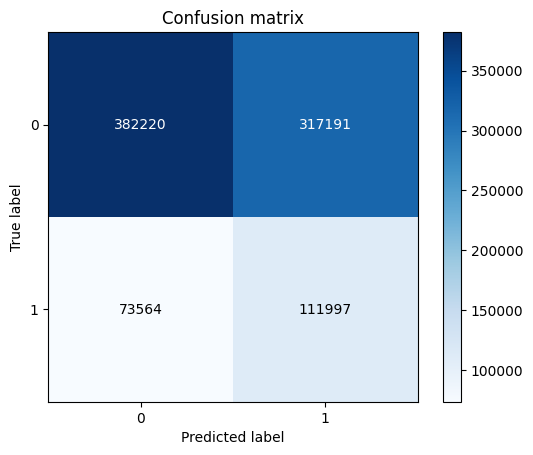

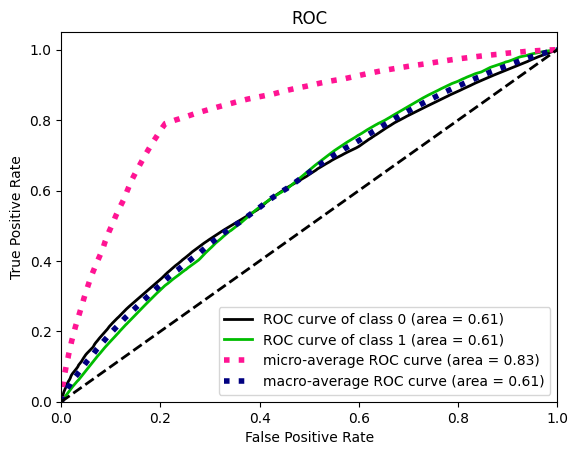

In [66]:
e_train = Evaluator(y_train, y_train_prob)
e_train.display_results()

In [67]:
# score the test

X_test_winsorized = winsorizer.transform(X_test)
X_test_standardized = standard_scaler.transform(X_test_winsorized)
y_test_prob_both = model.predict_proba(X_test_standardized)
y_test_prob = y_test_prob_both[:, 1]  # Probabilities for the positive class

Computing optimal Threshold: 0.19
Computing predictions...
AUC: 0.61
Optimal Threshold: 0.19
Maximum F1 Score: 0.38
              precision    recall  f1-score   support

           0       0.87      0.39      0.53     77713
           1       0.25      0.77      0.38     20618

    accuracy                           0.47     98331
   macro avg       0.56      0.58      0.46     98331
weighted avg       0.74      0.47      0.50     98331



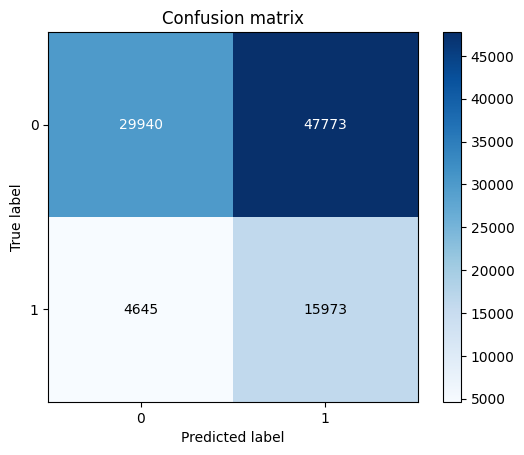

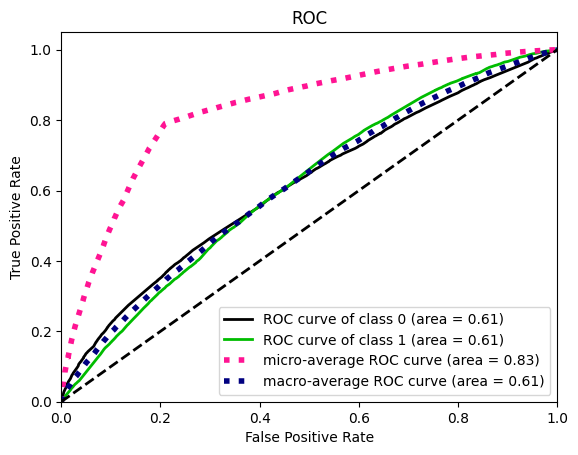

In [68]:
e_test = Evaluator(y_test, y_test_prob_both)
e_test.display_results()



In [69]:


from dataclasses import dataclass
from datetime import date

@dataclass(frozen=True)
class BTQueryConstants:
    end_date: date = date(2020, 9, 22)
    feature_duration: int = 365
    response_duration: int = 28
    additional_offset: int = 0

backtest_constants = BTQueryConstants()

# todo this is where dataset.run_query(query) would be good.  Returns DF.
# arrow_table = dataset.duckdb_conn.execute(backtest_feature_query).fetch_arrow_table()
features = Features(**vars(backtest_constants))

backtest_response_df  = features.get_response_label(dataset.duckdb_conn)
#backtest_feature_df = features.get_time_sliced_no_overlap(dataset.duckdb_conn)
backtest_feature_df = features.get_customer_features(dataset.duckdb_conn)

# todo: I do not use this view
# dataset.duckdb_conn.register("backtest_features", backtest_feature_df)

print(backtest_feature_df.shape)

# I'm preparing to score records ... for scoring I think ...
# def score(model, feature_df, pk_column) and returns something reasonable .. meaning I want to return
# a dataframe with customer_id, probability (or all classes to generalize to multi-class)
# and maybe evaluation could have a different constructor that takes a DF instead?

features_without_id = backtest_feature_df.drop("customer_id")

print(features_without_id.shape)

features_without_id_winsorized = winsorizer.transform(features_without_id.to_numpy())
features_without_id_standard = standard_scaler.transform(features_without_id_winsorized)

scores_prob_positive = model.predict_proba(features_without_id_standard)[:, 1]
backtest_pred = [1 if prob >= e_test.optimal_threshold else 0 for prob in scores_prob_positive]

scores_df = pl.DataFrame({
    "customer_id": backtest_feature_df["customer_id"],
    "score": scores_prob_positive,
    "prediction": backtest_pred
})



backtest_pred_truth_df = scores_df.join(backtest_response_df, on="customer_id")
dataset.duckdb_conn.register("scores", backtest_pred_truth_df)

backtest_response = np.array(backtest_pred_truth_df["label"])
backtest_score = np.array(backtest_pred_truth_df["score"])






(986035, 8)
(986035, 7)


Computing predictions...
AUC: 0.61
Optimal Threshold: 0.19
Maximum F1 Score: 0.37
              precision    recall  f1-score   support

           0       0.86      0.38      0.52    783633
           1       0.24      0.77      0.37    202402

    accuracy                           0.46    986035
   macro avg       0.55      0.57      0.45    986035
weighted avg       0.73      0.46      0.49    986035



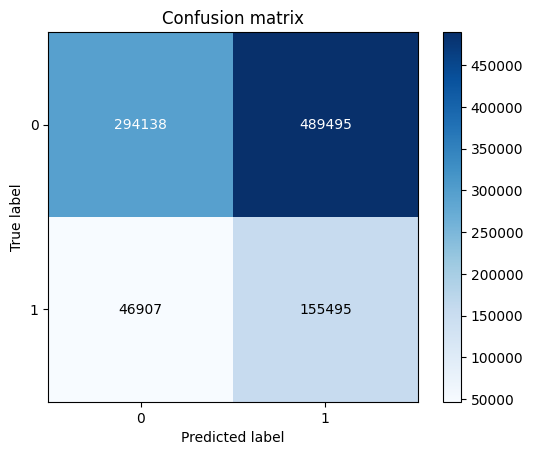

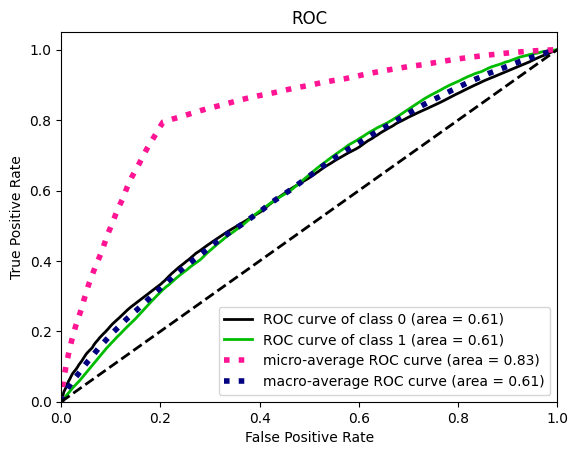

In [70]:
e_backtest = Evaluator(backtest_response, backtest_score, threshold=e_test.optimal_threshold)

e_backtest.display_results()


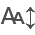

decile,buyer_count,scored_customer_count,non_buyer_count
i64,"decimal[38,0]",i64,"decimal[38,0]"
10,8310,98603,90293
9,13106,98603,85497
8,17966,98603,80637
7,17480,98603,81123
6,21655,98603,76948
5,20826,98604,77778
4,22571,98604,76033
3,23608,98604,74996
2,27130,98604,71474


In [71]:
# todo this is where I want to encapsulate the display of response curve ??? or do I care
# the display can be encapsulated ... but perhaps the computatiopn of DF still stays
# in notebook for now

# query = ''''
#
# SELECT decile, SUM(bought) buyer_count, COUNT(1) scored_customer_count, COUNT(1) - SUM(bought) non_buyer_count
# FROM (
#     SELECT s.customer_id, ntile(10) OVER (ORDER BY score desc) AS decile, COALESCE(bought,0) as bought
#     from scores s
#     left outer join (
#         SELECT customer_id, COUNT(distinct t.customer_id) bought
#         from transactions t
#         WHERE t_dat > DATE '{feature_end}'
#         GROUP BY customer_id
#     ) t on t.customer_id = s.customer_id
#     GROUP BY s.customer_id, score, bought
# ) x
# GROUP BY decile
# ORDER BY decile DESC
# '''.format(feature_end=BTQueryConstants.feature_end)

query = '''
    SELECT decile, SUM(bought) buyer_count, COUNT(1) scored_customer_count, COUNT(1) - SUM(bought) non_buyer_count
    FROM (
        SELECT s.customer_id, ntile(10) OVER (ORDER BY score desc) AS decile, label as bought
        from scores s
        GROUP BY s.customer_id, score, label
    ) x
    GROUP BY decile
    ORDER BY decile DESC

'''

backtest_results = dataset.run_query_display_results(query)
# backtest - use the new features and labels code I think firstly
# scoring ... leave this open for now

# I can use the feature query constant and set the correct parameters to get the backtest features

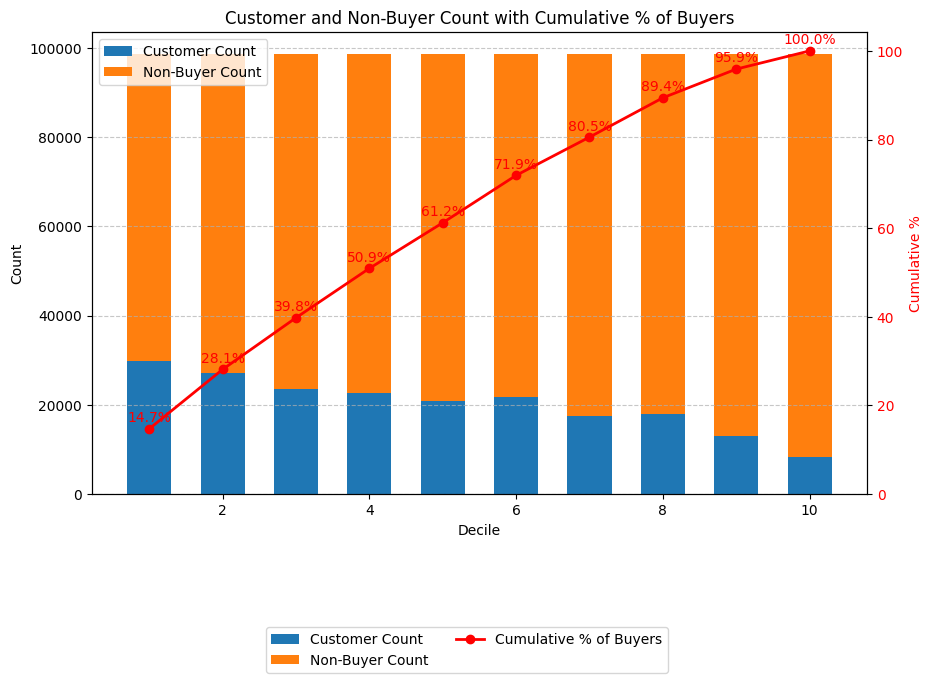

In [72]:


# plot the response curve ... put into a class
import matplotlib.pyplot as plt

# Assuming data is already created
data = backtest_results.to_pandas()

# Sort the DataFrame by decile in ascending order
data = data.sort_values(by="decile", ascending=True)

data["cumulative_percent"] = (data["buyer_count"].cumsum() / data["buyer_count"].sum() * 100)

# Extract columns as lists
decile = data["decile"].to_list()
customer_count = data["buyer_count"].to_list()
non_buyer_count = data["non_buyer_count"].to_list()
cumulative_percent = data["cumulative_percent"].to_list()

# print(cumulative_percent)
# print(customer_count)

# Create the figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the stacked bar chart
ax1.bar(decile, customer_count, label="Customer Count", width=0.6)
ax1.bar(decile, non_buyer_count, bottom=customer_count, label="Non-Buyer Count", width=0.6)

# Label for the primary y-axis
ax1.set_xlabel('Decile')
ax1.set_ylabel('Count')
ax1.set_title('Customer and Non-Buyer Count with Cumulative % of Buyers')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(loc="upper left")

# Create a secondary y-axis for cumulative percent
ax2 = ax1.twinx()
ax2.plot(decile, cumulative_percent, color="red", marker="o", label="Cumulative % of Buyers", linewidth=2)
ax2.set_ylabel('Cumulative %', color='red')
ax2.tick_params(axis='y', labelcolor='red')

for x, y in zip(decile, cumulative_percent):
    ax2.annotate(f"{y:.1f}%", (x, y), textcoords="offset points", xytext=(0, 5), ha='center', color="red")

# Set the secondary y-axis to start at 0
ax2.set_ylim(0, ax2.get_ylim()[1])  # Start from 0, keep the max limit as it is


# Combine legends from both axes
fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)

# Show the plot
plt.show()

# this is not yet how I want it to look but will need to do for the time being

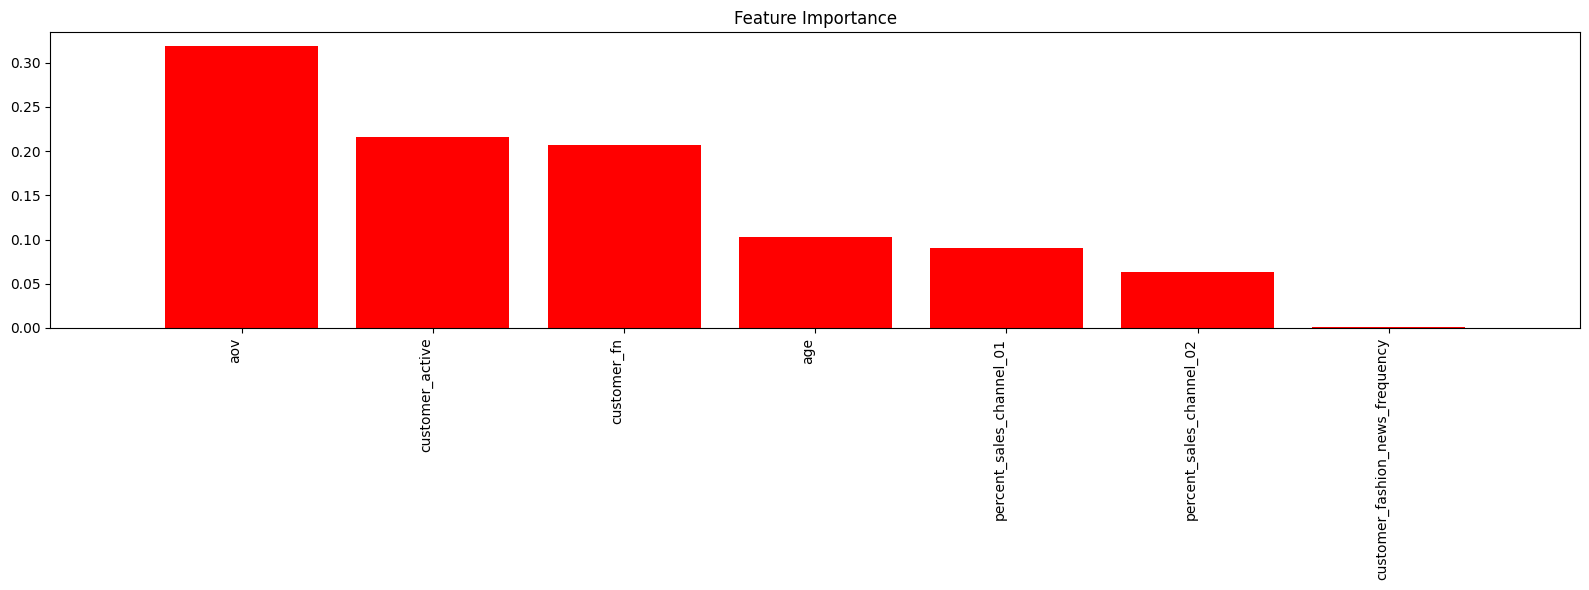

In [73]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Feature Importance
if isinstance(model, LogisticRegression):
    importance = model.coef_[0]
elif isinstance(model, RandomForestClassifier):
    importance = model.feature_importances_

indices = np.argsort(importance)[::-1]

# Create the plot with more space for labels
plt.figure(figsize=(16, 6))  # Adjust the width (12) and height (6) as needed
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importance[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), [feature_columns[i] for i in indices], rotation=90, ha='right')  # Rotate labels
plt.xlim([-1, X.shape[1]])
plt.tight_layout()  # Automatically adjust subplot parameters to give space for labels
plt.show()